# Baseline proportions

For each percentile, get the expected ratio of counts - that is, according to the baseline counts for all words, the proportion of the words that are expected to fall into each bucket.

In [1]:
y1 = 1800
y2 = 1920

In [2]:
from lint.models import Offset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [3]:
baseline_counts = Offset.baseline_series(y1, y2)

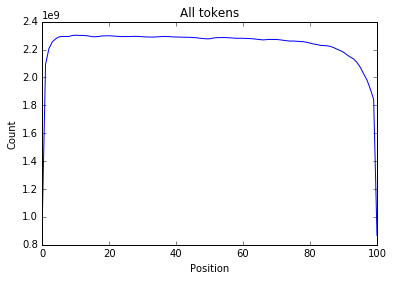

In [4]:
plt.title('All tokens')
plt.xlabel('Position')
plt.ylabel('Count')
plt.plot(*zip(*baseline_counts.items()))
plt.show()

In [6]:
total_count = sum(baseline_counts.values())

baseline_ratios = {
    offset: count / total_count
    for offset, count in baseline_counts.items()
}

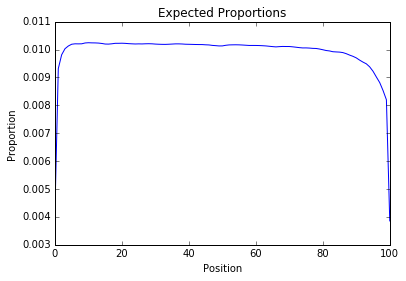

In [7]:
plt.title('Expected Proportions')
plt.xlabel('Position')
plt.ylabel('Proportion')
plt.plot(*zip(*baseline_ratios.items()))
plt.show()

# Expected vs. observed

Now, for any given token, we can plot the actual series against the series that would be expected based on the overall count for the token.

In [19]:
def plot_expected_vs_observed(token):
    
    observed = Offset.token_series(token, y1, y2)
    
    total_count = sum(observed.values())

    expected = {
        offset: baseline_ratios[offset] * total_count
        for offset, count in observed.items()
    }
    
    print(token)
    
    plt.title('Expected vs. Observed')
    plt.xlabel('Offset')
    plt.ylabel('Count')
    plt.plot(*zip(*expected.items()), color='gray')
    plt.plot(*zip(*observed.items()))
    plt.show()

the


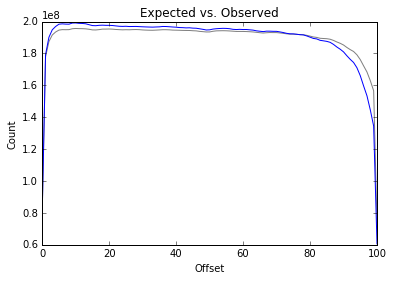

she


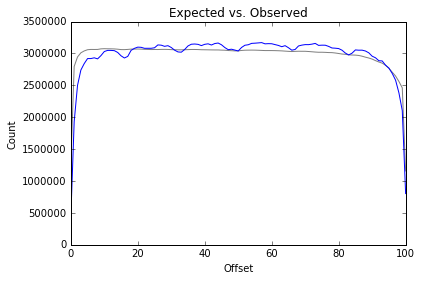

her


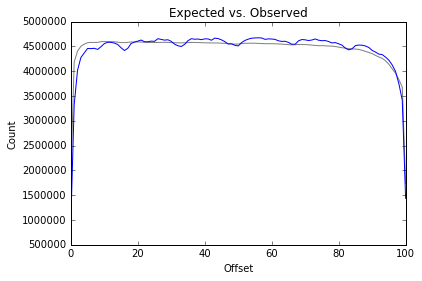

library


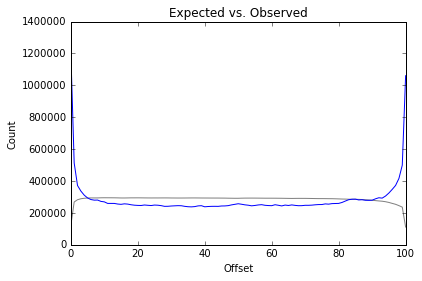

In [22]:
plot_expected_vs_observed('the')
plot_expected_vs_observed('she')
plot_expected_vs_observed('her')
plot_expected_vs_observed('library')